##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [136]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Poke2Poke


This notebook shows how we can generate other pokemons using transitions in the latent space.

## Import TensorFlow and other libraries

In [34]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
import numpy as np

## Load the dataset

Copy pokemon images from drive.

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
BASE_PATH = '/content/drive/MyDrive/Redes_Neuronales/pokemon_evolutions/'
#BASE_PATH = '/content/drive/MyDrive/Pokemon/'

EVOLUTIONS_FILE_PATH = os.path.join(BASE_PATH, 'evolutions.txt')
IMAGES_PATH = os.path.join(BASE_PATH, 'sprites/')
ALL_PATH = os.path.join(IMAGES_PATH, 'all/')

In [4]:
OUTPUT_CHANNELS = 3

In [5]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [56]:
img_height = 64
img_width = 64
latent_dim = 16

In [7]:
@tf.function
def load_both(path_1, path_2):

  input_image = tf.io.read_file(path_1)
  input_image = tf.image.decode_png(input_image, channels=4)

  output_image = tf.io.read_file(path_2)
  output_image = tf.image.decode_png(output_image, channels=4)

  input_image = tf.cast(input_image, tf.float32)
  output_image = tf.cast(output_image, tf.float32)

  return input_image, output_image


In [8]:
#@tf.function
def load_img(path):
  # Load png
  input_image = tf.io.read_file(path)
  input_image = tf.image.decode_png(input_image, channels=4)
  
  # Cast float
  input_image = tf.cast(input_image, tf.float32)

  return input_image

#@tf.function
def remove_alpha(input_image):

  assert len(input_image.shape) == 3

  # Get normalized alpha
  mask = tf.expand_dims(input_image[:,:,3], axis=-1)
  # Multiply with every other channel (3)
  input_image = input_image[:,:,:3] * tf.repeat(mask, repeats=3, axis=-1)

  return input_image

#@tf.function
def random_crops(x1, x2):
  # Resize and give 6px on each dim to random crop
  x1 = tf.image.resize(x1, [img_height + 6, img_width + 6],
                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  x2 = tf.image.resize(x2, [img_height + 6, img_width + 6],
                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  #stack both imgs
  stacked = tf.stack([x1, x2])
  
  # Crop to 64x64
  input_images = tf.image.random_crop(stacked, size=[2, img_height, img_width, 4])
  
  return input_images[0, ...], input_images[1, ...]

#@tf.function
def preprocess_imgs(x1, x2):
  x1, x2 = random_crops(x1, x2)
  x1 = x1 / 255
  x2 = x2 / 255
  x1 = remove_alpha(x1)
  x2 = remove_alpha(x2)
  return x1, x2

In [9]:
@tf.function
def load_images(images_paths):
  image_file_1 = images_paths[0]
  image_file_2 = images_paths[1]
  input_image, real_image = load_both(image_file_1, image_file_2)

  input_image, real_image = preprocess_imgs(input_image, real_image)

  return input_image, real_image

In [73]:
@tf.function
def load_and_preprocess_img(path):
  # Load png
  input_image = tf.io.read_file(path)
  input_image = tf.image.decode_png(input_image, channels=4)
  
  # Cast float and normalize
  input_image = tf.cast(input_image, tf.float32) / 255


  input_image = tf.image.resize(input_image, [img_height + 6, img_width + 6],
                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  # Crop to 64x64
  input_image = tf.image.random_crop(input_image, size=[img_height, img_width, 4])
  input_image = remove_alpha(input_image)

  return input_image

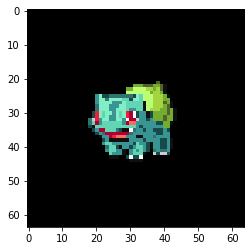

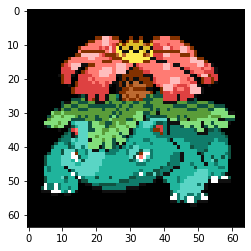

In [68]:
inp, re = load_images([ALL_PATH + '1.png', ALL_PATH + '3.png'])
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp)
plt.figure()
plt.imshow(re)

## Input Pipeline

In [11]:
all_dataset = tf.data.TextLineDataset(EVOLUTIONS_FILE_PATH)

In [12]:
ins = []
outs = []
for i in all_dataset.as_numpy_iterator(): 
  p1, p2 = i.split()
  ins.append(os.path.join(ALL_PATH, p1.decode('utf8')+'.png'))
  outs.append(os.path.join(ALL_PATH, p2.decode('utf8')+'.png'))

In [13]:
all_dataset = tf.data.Dataset.from_tensor_slices(list(zip(ins, outs)))
all_dataset = all_dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
all_dataset = all_dataset.shuffle(BUFFER_SIZE)
all_dataset = all_dataset.batch(BATCH_SIZE)

In [14]:
count = 0
for i1, i2 in all_dataset:
  count += 1
print(f"There are {count} batches in total")

There are 147 batches in total


## Import Encoder and Decoder

In [15]:
!cp {BASE_PATH}/encoder_CVAE.zip ./encoder.zip
!cp {BASE_PATH}/decoder_CVAE.zip ./decoder.zip

In [16]:
!unzip ./encoder.zip
!unzip ./decoder.zip

Archive:  ./encoder.zip
   creating: encoder_model/assets/
  inflating: encoder_model/saved_model.pb  
   creating: encoder_model/variables/
  inflating: encoder_model/variables/variables.index  
  inflating: encoder_model/variables/variables.data-00000-of-00001  
Archive:  ./decoder.zip
   creating: decoder_model/assets/
  inflating: decoder_model/saved_model.pb  
   creating: decoder_model/variables/
  inflating: decoder_model/variables/variables.index  
  inflating: decoder_model/variables/variables.data-00000-of-00001  


In [17]:
encoder = tf.keras.models.load_model("encoder_model")
decoder = tf.keras.models.load_model("decoder_model")

# Mean Delta

## Calculating a mean $\overline{\delta}$ inside latent space

The idea is to transform each sample to the latent space and calculate a mean delta vector between a pokemon's initial state and its evolution


In [19]:
for input_image, target in all_dataset.take(1):
  inp = input_image
  tar = target

In [20]:
inp.shape

TensorShape([1, 64, 64, 3])

In [51]:
# Save every delta for every training sample in dataset
deltas = []
for input_image, target in all_dataset:
  # Latent mu is first half of values
  latent_inp = encoder(input_image)[:, :latent_dim]
  latent_out = encoder(target)[:, :latent_dim]
  deltas.append(latent_out - latent_inp)
deltas = tf.concat(deltas, axis=0)

In [52]:
print(f"There are {deltas.shape[0]} deltas of shape {deltas[0].shape}")

There are 147 deltas of shape (16,)


In [53]:
delta_bar = tf.reduce_mean(deltas, axis=0)
delta_std = tf.math.reduce_std(deltas, axis=0)

## Visualize delta
Lets visualize how much is each dimension affected by the (mean) translation

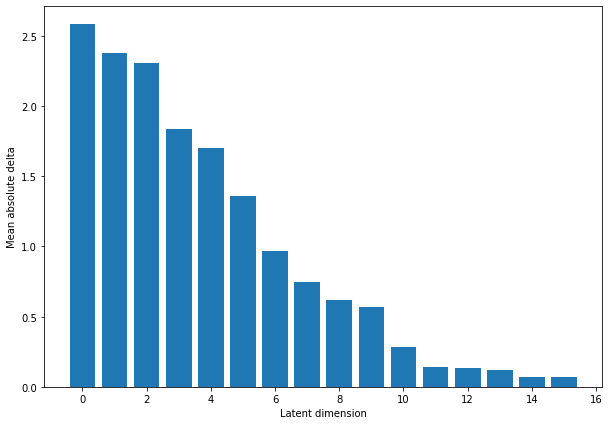

In [70]:
plt.figure(figsize=(10,7))
sorted_delta = sorted(np.abs(delta_bar.numpy()), reverse=True)
plt.bar(np.arange(latent_dim), sorted_delta)
plt.xlabel("Latent dimension")
plt.ylabel("Mean absolute delta")
plt.show()

Lets plot also the distribution for each of the delta dimensions

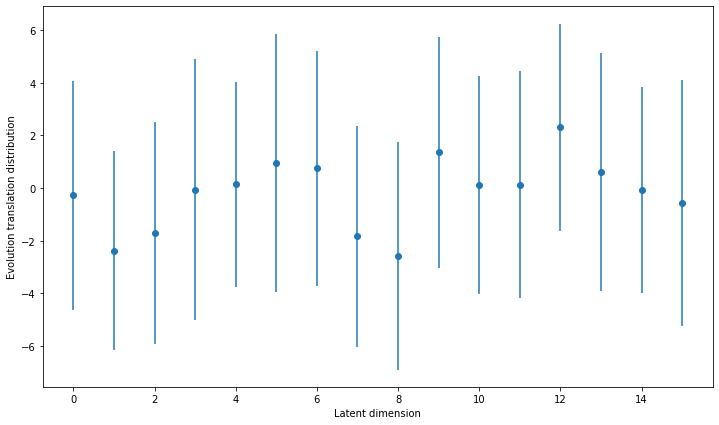

In [71]:
x = np.array(np.arange(latent_dim))
y = delta_bar.numpy()
e = delta_std.numpy()

plt.figure(figsize=(12, 7))

plt.errorbar(x, y, e, linestyle='None', marker='o')

plt.xlabel("Latent dimension")
plt.ylabel("Evolution translation distribution")

plt.show()

This tells us that no actual dimension is more important than other at translating a pokemon to its evolution. Further statistical analysis would be necessary to determine if these samples come from the same distribution, i.e. if there is an actual translation between a pokemon and its evolution, or it is all a bunch of mumbo jumbo.

# Evolving Pokemons

Lets now generate some evolutions to see if they make sense

## Auxiliar functions

In [133]:
"""
Evolve a batch of pokemons
"""
def evolve(poke):
  latent_poke = encoder(poke)[:, :16]
  latent_evol = latent_poke + tf.stack([delta_bar])
  evolved_poke = decoder(latent_evol)
  return tf.sigmoid(evolved_poke)

"""
Generate and plot a batch of pokemons to its predicted evolutions
BATCH_SIZE <= 16
"""
def generate_images(test_input):

  evolutions = evolve(test_input[:16, ...])
  plt.figure(figsize=(16, 8))

  title = ['Input Pokemon', 'Predicted Evolution']

  for i in range(evolutions.shape[0])[:16]:
    
    plt.subplot(4, 8, 2*i+1)
    plt.title(title[0])
    plt.imshow(test_input[i,...])
    plt.axis('off')

    plt.subplot(4, 8, 2*i+2)
    plt.title(title[1])
    plt.imshow(evolutions[i,...])
    plt.axis('off')

  plt.show()

## Input pipeline for pokemons

In [134]:
# List test images from directory
images = os.listdir(ALL_PATH)
images = [os.path.join(ALL_PATH, f) for f in images]

poke_dataset = tf.data.Dataset.from_tensor_slices(images)
poke_dataset = poke_dataset.map(load_and_preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
poke_dataset = poke_dataset.batch(16)

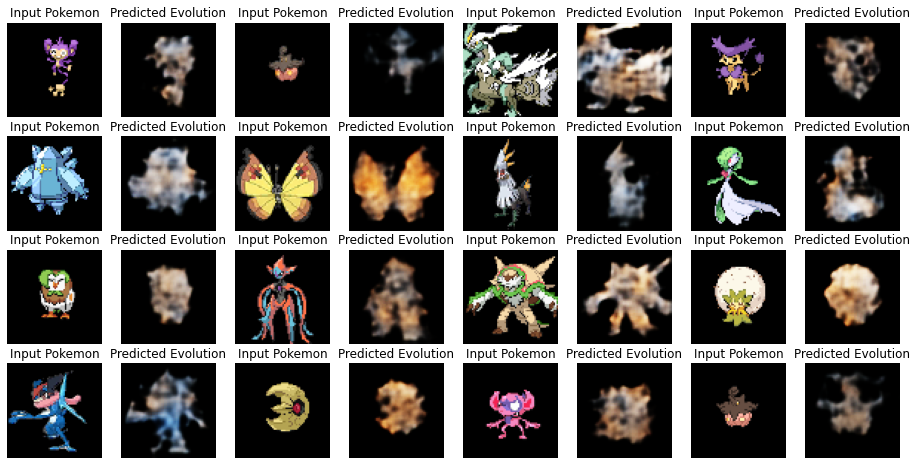

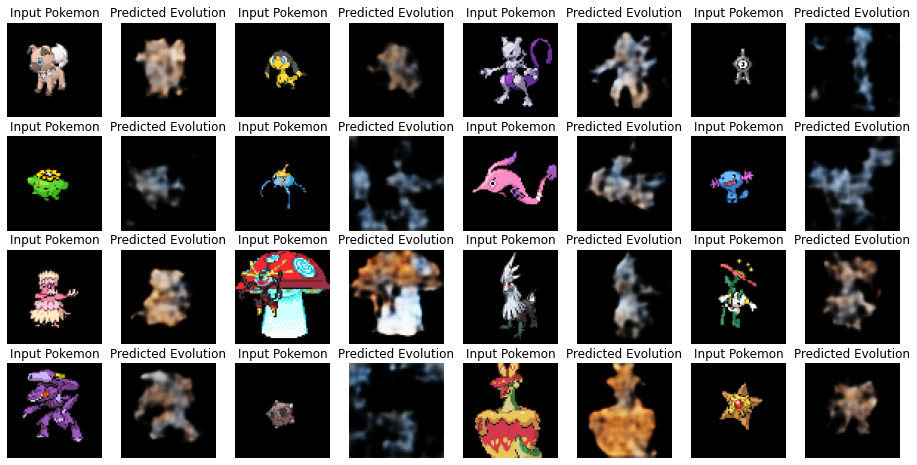

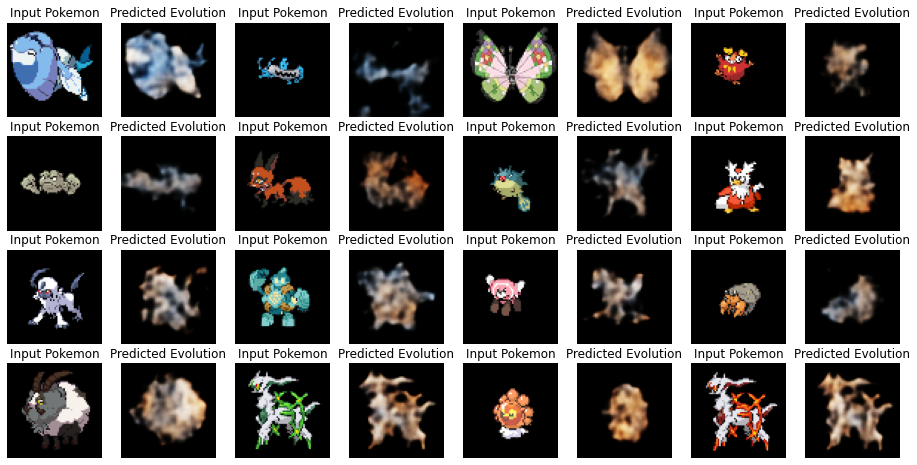

In [135]:
for batch in poke_dataset.take(3):
  generate_images(batch)